In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("mnist/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting mnist/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting mnist/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models

In [0]:
def read_initialization():
  
  # read weights from npz file
  weights = np.load('weights.npz')
  transferred_weights = weights['w2'].flatten()
 
  mean = transferred_weights.mean()
  stdev = transferred_weights.std()
  min_val = transferred_weights.min()
  max_val = transferred_weights.max()
  
  return dict(mean=mean, stdev=stdev, min_val=min_val, max_val=max_val)

In [0]:
rfa_params = read_initialization()
print(rfa_params)

{'mean': -0.54367393, 'stdev': 2.326689, 'min_val': -6.1726923, 'max_val': 4.7147255}


In [0]:
def create_bias(name, shape, value=0.0, dtype=tf.float32):
    # Declares a bias variable with constant initialization.

    return tf.get_variable(
        name=name,
        shape=shape,
        dtype=dtype,
        initializer=tf.constant_initializer(value, dtype=dtype))
#         initializer=tf.random_uniform_initializer(minval=min_val, maxval=max_val))


def create_weights(name, shape, feedback, mean, distribution_type, stddev=0.0, dtype=tf.float32):
    # Declares a weight variable with random normal or uniform initialization.
    
    rfa_params = read_initialization()
    
    if feedback == True:
      mean = rfa_params['mean']
      stddev = rfa_params['stdev']
    
    if distribution_type == 'normal':
      return tf.get_variable(
          name=name,
          shape=shape,
          dtype=dtype,
          initializer=tf.truncated_normal_initializer(mean=mean, stddev=stddev, dtype=dtype))
    
    elif distribution_type == 'uniform':
      if feedback == True:
        minval=rfa_params['min_val']
        maxval=rfa_params['max_val']
      else:
        minval=-0.5
        maxval=0.5
      return tf.get_variable(
            name=name,
            shape=shape,
            dtype=dtype,
            initializer=tf.random_uniform_initializer(minval=minval, maxval=maxval))
    else:
      print('Please specify a random distribution type')
      
def sigma(x):
    return tf.div(tf.constant(1.0),
                  tf.add(tf.constant(1.0), tf.exp(tf.negative(x))))
  
def sigmaprime(x):
    return tf.multiply(sigma(x), tf.subtract(tf.constant(1.0), sigma(x)))

In [0]:
class RFANormal(object):
    """Three-layer netowrk based on the Lillicrap et. al. RFA paper
    Following abilities:
        * bias term is drawn from random nr distribution
        * feedback weights drawn from a random normal distribution intialized on old weights
        * can change number of hidden units
        * uses cross-entropy in training
        * can initialize ranges to draw from using previously trained weights
    """
    scope = 'rfn'
    distribution_type = 'normal'
    
    def __init__(self, num_hidden=100, distribution_type=distribution_type):
        self.define_placeholders()
        self.define_network(num_hidden, distribution_type)
        self.define_costs()
        self.define_train_step(num_hidden, distribution_type)

    def define_network(self, num_hidden, distribution_type):
        with tf.variable_scope(self.scope, reuse=tf.AUTO_REUSE):
            self.w1 = create_weights("w1", [784, num_hidden], feedback=False, mean=0.0, distribution_type=distribution_type) # forward weights
            self.d1 = create_bias("d1", [num_hidden])
            self.z1 = tf.add(tf.matmul(self.x, self.w1), self.d1)
            self.h = sigma(self.z1)

            self.w2 = create_weights("w2", [num_hidden, 10], feedback=False, mean=0.0, distribution_type=distribution_type) # forward weights
            self.d2 = create_bias("d2", [10])
            self.z2 = tf.add(tf.matmul(self.h, self.w2), self.d2)
            self.ypred = tf.nn.softmax(self.z2)

    def define_train_step(self, num_hidden, distribution_type):
        # Create backward weights
        with tf.variable_scope(self.scope, reuse=tf.AUTO_REUSE):
            b2 = create_weights("b2", [10, num_hidden], feedback=True, mean=0.0, distribution_type=distribution_type)
            
        # training: derivative w.r.t. activations
        ypred_grad = tf.gradients(self.cross_entropy, self.ypred)[0]
        z2_grad = tf.gradients(self.cross_entropy, self.z2)[0] # Using softmax
        
        h_grad = tf.matmul(z2_grad, b2)
        z1_grad = tf.multiply(tf.gradients(self.h, self.z1)[0], h_grad)
        
        # training: derivative w.r.t. weights
        self.w2_grad = tf.reduce_sum(
                tf.multiply(tf.expand_dims(self.h, 2),
                       tf.expand_dims(z2_grad, 1)), # order?
                [0])
        self.d2_grad = tf.reduce_sum(z2_grad, [0])
        self.w1_grad = tf.reduce_sum(
                tf.multiply(tf.expand_dims(self.x, 2),
                       tf.expand_dims(z1_grad, 1)), # order?
                [0])
        self.d1_grad = tf.reduce_sum(z1_grad, [0])
        
        # training: assign weights
        self.train_step= [
            tf.assign(self.w2, self.w2 - self.alpha * self.w2_grad - self.decay),
            tf.assign(self.w1, self.w1 - self.alpha * self.w1_grad - self.decay),
            tf.assign(self.d2, self.d2 - self.alpha * self.d2_grad - self.decay),
            tf.assign(self.d1, self.d1 - self.alpha * self.d1_grad - self.decay),
        ]
    
    def define_placeholders(self):
        self.x = tf.placeholder(tf.float32, [None, 784])
        self.y = tf.placeholder(tf.float32, [None, 10])
        self.lr = tf.placeholder(tf.float32) # learning rate
        self.decay = tf.placeholder(tf.float32) # weight decay
        self.N = tf.cast(tf.shape(self.x)[0], tf.float32)
        self.alpha = self.lr # / self.N

    def define_costs(self):
        # cross-entropy
        self.cross_entropy = tf.reduce_mean(
                -tf.reduce_sum(self.y * tf.log(self.ypred), reduction_indices=[1]))
        # acurracy
        correct_prediction = tf.equal(tf.argmax(self.ypred,1), tf.argmax(self.y,1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    def train(self, sess, mnist, lr=0.5, decay=0.0, epochs=50, verbose=False):
        # returns accuracy for both train and test set, and the weights in the final layer
        testaccs = []
        trainaccs = []
        for e in range(epochs):
            for b in range(60):
                images, labels = mnist.train.next_batch(1000)
                sess.run(self.train_step,
                        feed_dict={self.x: images,
                                   self.y: labels,
                                   self.lr: lr,
                                   self.decay: decay
                                   })
            train_acc = sess.run(self.accuracy,
                    feed_dict={self.x: mnist.train.images,
                               self.y: mnist.train.labels })
            acc = sess.run(self.accuracy,
                    feed_dict={self.x: mnist.test.images,
                               self.y: mnist.test.labels })
            trainaccs.append(train_acc)
            testaccs.append(acc)
            # print ('Epoch %d, TrainAcc: %.1f %%, TestAcc: %.1f', e, train_acc*100, acc*100)
        return trainaccs, testaccs, self.w2

In [0]:
class RFAUniform(RFANormal):
    """Three-layer netowrk based on the Lillicrap et. al. RFA paper
    Following abilities:
        * bias term is drawn from random uniform distribution
        * feedback weights drawn from random uniform distirbuton initialized on old weight parameters
        * can change number of hidden units
        * uses cross-entropy in training
        * can initialize ranges to draw from using previously trained weights
    """
    scope = 'rfn'
    distribution_type = 'uniform'
    
    def __init__(self, num_hidden=100, distribution_type=distribution_type):
        self.define_placeholders()
        self.define_network(num_hidden, distribution_type)
        self.define_costs()
        self.define_train_step(num_hidden, distribution_type)

In [0]:
rfa_norm = RFANormal()
rfa_uni = RFAUniform()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use tf.cast instead.


In [0]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [0]:
%%time
ntraining_acc, ntesting_acc, nfinal_w2 = rfa_norm.train(sess, mnist, lr=0.5, decay=0.00001, epochs=50, verbose=False)

CPU times: user 29.9 s, sys: 10.3 s, total: 40.2 s
Wall time: 32.8 s


In [0]:
%%time
sess.run(tf.global_variables_initializer())
utraining_acc, utesting_acc, ufinal_w2 = rfa_uni.train(sess, mnist, lr=0.5, decay=0.00001, epochs=50, verbose=False)

CPU times: user 29.9 s, sys: 10 s, total: 39.9 s
Wall time: 32.1 s


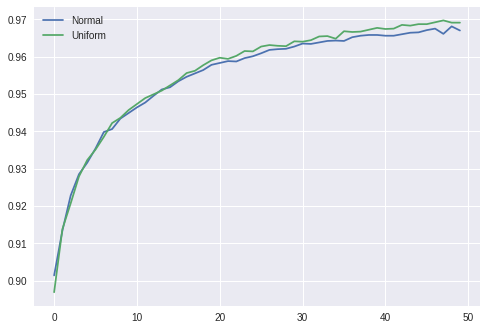

In [0]:
plt.plot(ntesting_acc, label="Normal")
plt.plot(utesting_acc, label="Uniform")
plt.legend()

In [0]:
#bpn_w2

In [0]:
#rfn_w2.eval()